In [185]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, votable
from astropy.table import Table, vstack, hstack
import astropy.units as u

dir_rrlyrae = '/datascope/menard/group/scheng/Gaia/'

In [515]:
isochrone_sun = Table.read('/home/scheng/Gaia/5Gyr_0.0152.dat',format='ascii')
isochrone_old = Table.read('/home/scheng/Gaia/10Gyr_0.0152.dat',format='ascii')
isochrone_mpoor = Table.read('/home/scheng/Gaia/10Gyr_0.000152.dat',format='ascii')
isochrone_old

Zini,Age,Mini,Mass,logL,logTe,logg,label,McoreTP,C_O,period0,period1,pmode,Mloss,tau1m,X,Y,Xc,Xn,Xo,Cexcess,Z,mbolmag,Gmag,G_BPmag,G_RPmag
float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0152,10000000000.0,0.0900000036,0.09,-3.423,3.3625,5.217,1,0.0,0.545,0.0,0.0,-1,0.0,0.0,0.708,0.2767,0.002746,0.0007408,0.006719,-1.0,0.01527,13.327,15.495,18.812,14.112
0.0152,10000000000.0,0.1000000015,0.1,-3.24,3.3884,5.184,1,0.0,0.545,0.0,0.0,-1,0.0,0.0,0.7076,0.2771,0.002746,0.0007408,0.006719,-1.0,0.01527,12.871,14.758,17.793,13.398
0.0152,10000000000.0,0.1077039689,0.108,-3.133,3.4026,5.165,1,0.0,0.545,0.0,0.0,-1,0.0,0.0,0.7072,0.2775,0.002746,0.0007408,0.006719,-1.0,0.01527,12.601,14.346,17.188,13.003
0.0152,10000000000.0,0.1200000122,0.12,-2.975,3.4232,5.137,1,0.0,0.545,0.0,0.0,-1,1.04e-16,0.0,0.7067,0.278,0.002746,0.0007408,0.006719,-1.0,0.01527,12.209,13.759,16.281,12.449
0.0152,10000000000.0,0.1400000006,0.14,-2.792,3.4435,5.102,1,0.0,0.545,0.0,0.0,-1,1.53e-16,0.0,0.706,0.2788,0.002746,0.0007408,0.006719,-1.0,0.01527,11.749,13.11,15.333,11.84
0.0152,10000000000.0,0.1496137679,0.15,-2.721,3.4502,5.087,1,0.0,0.545,0.0,0.0,-1,0.0,0.0,0.7056,0.2791,0.002746,0.0007408,0.006719,-1.0,0.01527,11.573,12.877,15.0,11.622
0.0152,10000000000.0,0.1599999964,0.16,-2.65,3.4571,5.073,1,0.0,0.545,0.0,0.0,-1,0.0,0.0,0.7053,0.2794,0.002746,0.0007408,0.006719,-1.0,0.01527,11.395,12.643,14.665,11.403
0.0152,10000000000.0,0.200000003,0.2,-2.43,3.4758,5.025,1,0.0,0.545,0.0,0.0,-1,0.0,0.0,0.7042,0.2806,0.002746,0.0007408,0.006719,-1.0,0.01527,10.846,11.953,13.725,10.759
0.0152,10000000000.0,0.25,0.25,-2.217,3.4921,4.974,1,0.0,0.545,0.0,0.0,-1,0.0,0.0,0.7033,0.2814,0.002746,0.0007408,0.006719,-1.0,0.01527,10.314,11.305,12.894,10.151


## load npy file

In [ ]:
with_rv_all = np.load('/home/scheng/Gaia/with_rv_all.npy')[0]['with_rv_all']
len(with_rv_all)

## define variables

In [894]:
table = with_rv_all.copy()
bp_rp = np.array(table['bp_rp'])
g = np.array(table['phot_g_mean_mag'])
l = table['l']
b = table['b']
ra = table['ra']
dec = table['dec']

d = 1 / np.array(table['parallax'])*u.kpc
e_d = d * np.array(table['parallax_error']/table['parallax'])
X = - d * np.array(np.cos(b/180*np.pi) * np.cos(l/180*np.pi))
Y = d * np.array(np.cos(b/180*np.pi) * np.sin(l/180*np.pi))
Z = d * np.array(np.sin(b/180*np.pi))
pmra = np.array(table['pmra'])*1*u.mas/u.yr
pmdec = np.array(table['pmdec'])*1*u.mas/u.yr
pm_abs = np.sqrt(pmra**2 + pmdec**2)
rv = np.array(table['radial_velocity'])*u.km/u.s

from astropy.coordinates import ICRS, Galactic
galactic = ICRS(ra=ra, dec=dec,distance=d,\
      pm_ra_cosdec=pmra, pm_dec=pmdec,radial_velocity=rv).transform_to(Galactic)

U = galactic.velocity.d_x
V = galactic.velocity.d_y
W = galactic.velocity.d_z

## import dustmap

In [524]:
from astropy.coordinates import SkyCoord
from dustmaps.planck import PlanckQuery
from dustmaps.sfd import SFDQuery
from dustmaps.bayestar import BayestarQuery

from dustmaps.config import config
config['data_dir'] = '/datascope/menard/group/scheng/dust/dustmaps'

coords = SkyCoord(l*1*u.deg, b*1*u.deg, distance=(10**((g-0.7+5)/5))*u.pc, frame='galactic')

#planck = PlanckQuery()
#planck(coords)

sfd = SFDQuery()
sfd_ext = sfd(coords)

bayestar = BayestarQuery() # Bayestar2017 is the default
bayestar_ext = bayestar(coords, mode='median')

/home/scheng/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median for 1863287 results
  r = func(a, **kwargs)


## abs(BP-RP - 0.75 ) < 0.1

# All colors

/home/scheng/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


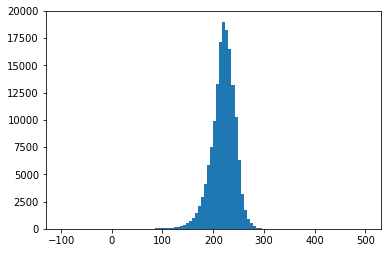

In [927]:
selected = (d > 0) * (np.abs(bp_rp-0.75)<10.25) * (np.abs(Z.value+0.03)<0.01) * (np.abs(X.value-5)<122.5) \
                    *(rv.value>-100000) * (pm_abs.value>-100000000)



data_x = X[selected]
data_y = Y[selected]

theta = np.arctan2(Y.value,X.value+8.2)
vr = ((U.value+13)*np.cos(theta)-(V.value+240)*np.sin(theta))[selected]
vphi = ((V.value+240)*np.cos(theta)+(U.value+13)*np.sin(theta))[selected]


plt.hist(vphi, bins=100,range=(-100,500))
plt.show()

/home/scheng/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/home/scheng/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/scheng/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/scheng/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10


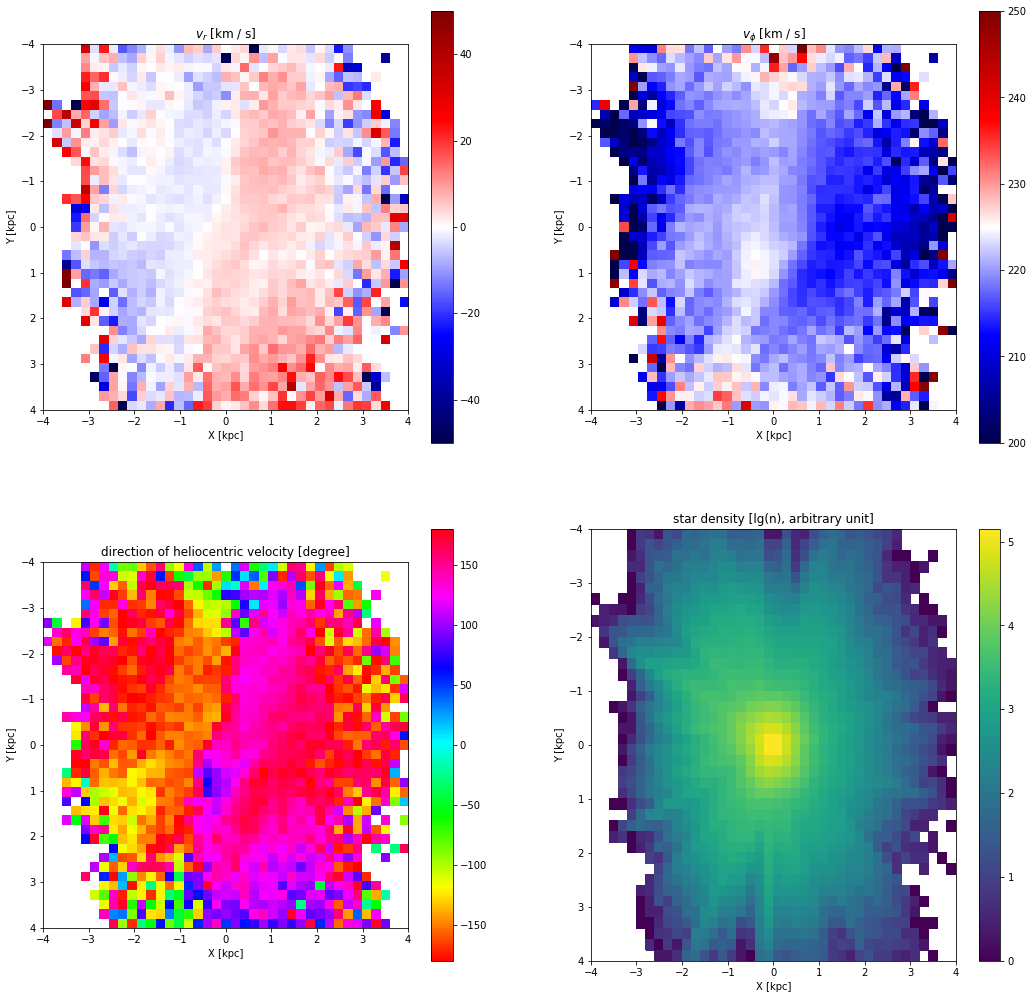

In [939]:
def plot_median(data_x, data_y, data_z, x1 = -4, x2 = 4, y1 = -4, y2 = 4, n = 40):    
    X_range = np.linspace(x1,x2,n)*u.kpc
    Y_range = np.linspace(y1,y2,n)*u.kpc
    average_array = np.empty((len(X_range)-1,len(Y_range)-1))
    for i,x_coor in enumerate(X_range[:-1]):
        for j,y_coor in enumerate(Y_range[:-1]):
            average_array[i,j] = (np.median(data_z[(data_x>X_range[i])*(data_x<X_range[i+1])*\
                                               (data_y>Y_range[j])*(data_y<Y_range[j+1])]))       
    return average_array


selected = (d > 0) * (np.abs(bp_rp-0.75)<10.25) * (np.abs(Z.value+0.03)<0.2) * (np.abs(X.value-5)<122.5) \
                    *(rv.value>-100000) * (pm_abs.value>-100000000)



data_x = X[selected]
data_y = Y[selected]

theta = np.arctan2(Y.value,X.value+8.2)
vr = ((U.value+13)*np.cos(theta)-(V.value+240)*np.sin(theta))[selected]
vphi = ((V.value+240)*np.cos(theta)+(U.value+13)*np.sin(theta))[selected]


x1 = -4; x2 = 4; y1 = 4; y2 = -4; n = 40
plt.figure(figsize=(18,27)) 

plt.subplot(3,2,3)
plt.title('direction of heliocentric velocity [degree]')
vdirection_field = 180/np.pi*np.arctan2(plot_median(data_x, data_y, vr).T , plot_median(data_x, data_y, vphi-225).T )
plt.imshow(vdirection_field,\
           extent=[x1,x2,y1,y2],cmap='hsv')
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.colorbar()

plt.subplot(3,2,4)
plt.title('star density [lg(n), arbitrary unit]')
H, xedges, yedges = np.histogram2d(X[selected], Y[selected], bins=(n, n),range=((x1,x2),(min(y1,y2),max(y1,y2))))
H = H.T
X_display, Y_display = np.meshgrid(xedges, yedges)
plt.pcolormesh(X_display, Y_display, np.log10(H))
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.xlim(x1,x2)
plt.ylim(y1,y2)
plt.colorbar()

plt.subplot(3,2,1)
plt.title('$v_r$ [km / s]')
vr_field = plot_median(data_x, data_y, vr).T
plt.imshow(vr_field,\
           extent=[x1,x2,y1,y2],vmin=-50,vmax=50,cmap='seismic')
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.colorbar()

plt.subplot(3,2,2)
plt.title('$v_\phi$ [km / s]')
vphi_field = plot_median(data_x, data_y, vphi).T
plt.imshow(vphi_field,\
           extent=[x1,x2,y1,y2],vmin=200,vmax=250,cmap='seismic')
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.colorbar()


plt.show()

In [949]:
selected = (d > 0) * (np.abs(bp_rp-0.75)<10.25) * (np.abs(Z.value+0.03)<0.2) * (np.abs(X.value-5)<122.5) \
                    *(rv.value>-100000) * (pm_abs.value>-100000000)
selected.sum()

/home/scheng/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


2822722

/home/scheng/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/home/scheng/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/scheng/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/scheng/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/scheng/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10


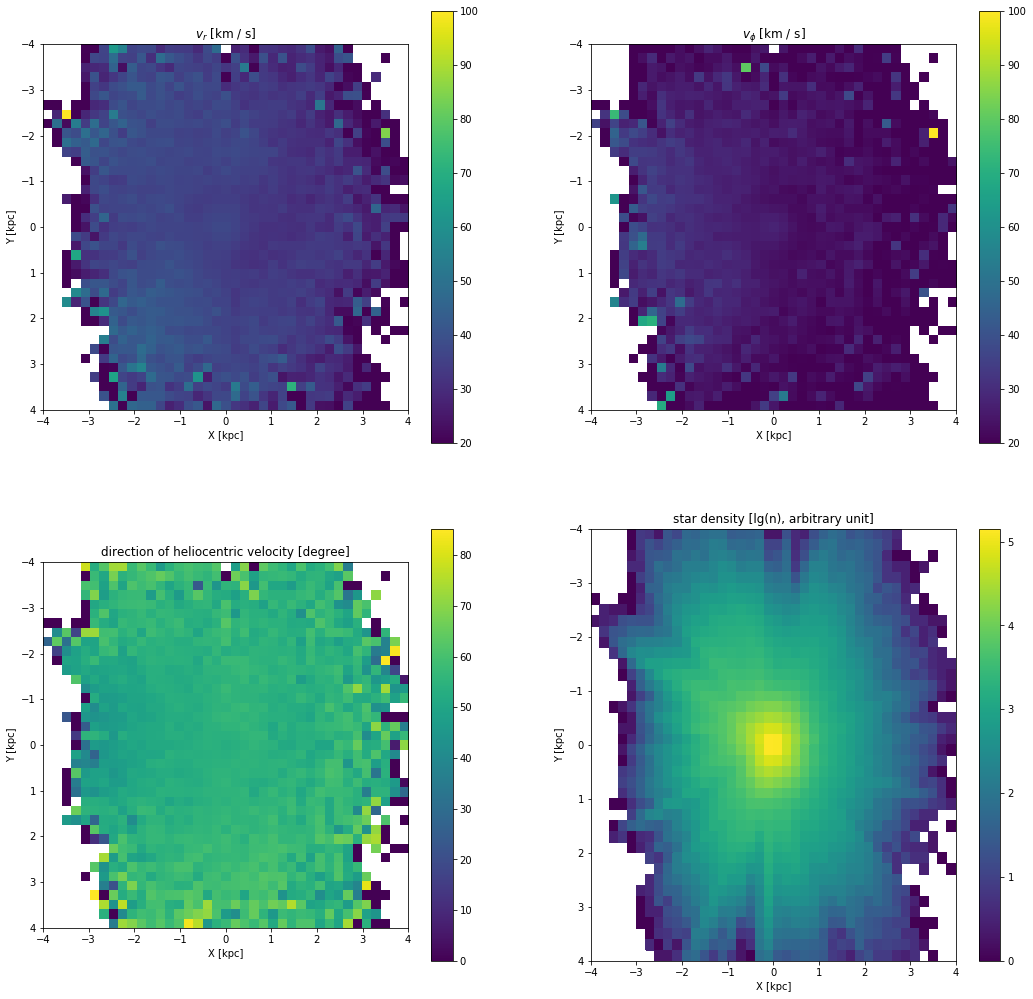

In [938]:
def plot_std(data_x, data_y, data_z, x1 = -4, x2 = 4, y1 = -4, y2 = 4, n = 40):    
    X_range = np.linspace(x1,x2,n)*u.kpc
    Y_range = np.linspace(y1,y2,n)*u.kpc
    average_array = np.empty((len(X_range)-1,len(Y_range)-1))
    for i,x_coor in enumerate(X_range[:-1]):
        for j,y_coor in enumerate(Y_range[:-1]):
            average_array[i,j] = (np.std(data_z[(data_x>X_range[i])*(data_x<X_range[i+1])*\
                                               (data_y>Y_range[j])*(data_y<Y_range[j+1])]))       
    return average_array


selected = (d > 0) * (np.abs(bp_rp-0.75)<10.25) * (np.abs(Z.value+0.03)<0.2) * (np.abs(X.value-5)<122.5) \
                    *(rv.value>-100000) * (pm_abs.value>-100000000)



data_x = X[selected]
data_y = Y[selected]

theta = np.arctan2(Y.value,X.value+8.2)
vr = ((U.value+13)*np.cos(theta)-(V.value+240)*np.sin(theta))[selected]
vphi = ((V.value+240)*np.cos(theta)+(U.value+13)*np.sin(theta))[selected]


x1 = -4; x2 = 4; y1 = 4; y2 = -4; n = 40
plt.figure(figsize=(18,27)) 

plt.subplot(3,2,3)
plt.title('direction of heliocentric velocity [degree]')
vdirection_field_std = 180/np.pi*np.arctan2(plot_std(data_x, data_y, vr).T , plot_std(data_x, data_y, vphi-225).T )
plt.imshow(vdirection_field_std,\
           extent=[x1,x2,y1,y2])
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.colorbar()

plt.subplot(3,2,4)
plt.title('star density [lg(n), arbitrary unit]')
H, xedges, yedges = np.histogram2d(X[selected], Y[selected], bins=(n, n),range=((x1,x2),(min(y1,y2),max(y1,y2))))
H = H.T
X_display, Y_display = np.meshgrid(xedges, yedges)
plt.pcolormesh(X_display, Y_display, np.log10(H))
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.xlim(x1,x2)
plt.ylim(y1,y2)
plt.colorbar()

plt.subplot(3,2,1)
plt.title('$v_r$ [km / s]')
vr_field_std = plot_std(data_x, data_y, vr).T
plt.imshow(vr_field_std,\
           extent=[x1,x2,y1,y2],vmin=20,vmax=100)
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.colorbar()

plt.subplot(3,2,2)
plt.title('$v_\phi$ [km / s]')
vphi_field_std = plot_std(data_x, data_y, vphi).T
plt.imshow(vphi_field_std,\
           extent=[x1,x2,y1,y2],vmin=20,vmax=100)
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.colorbar()


plt.show()

/home/scheng/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


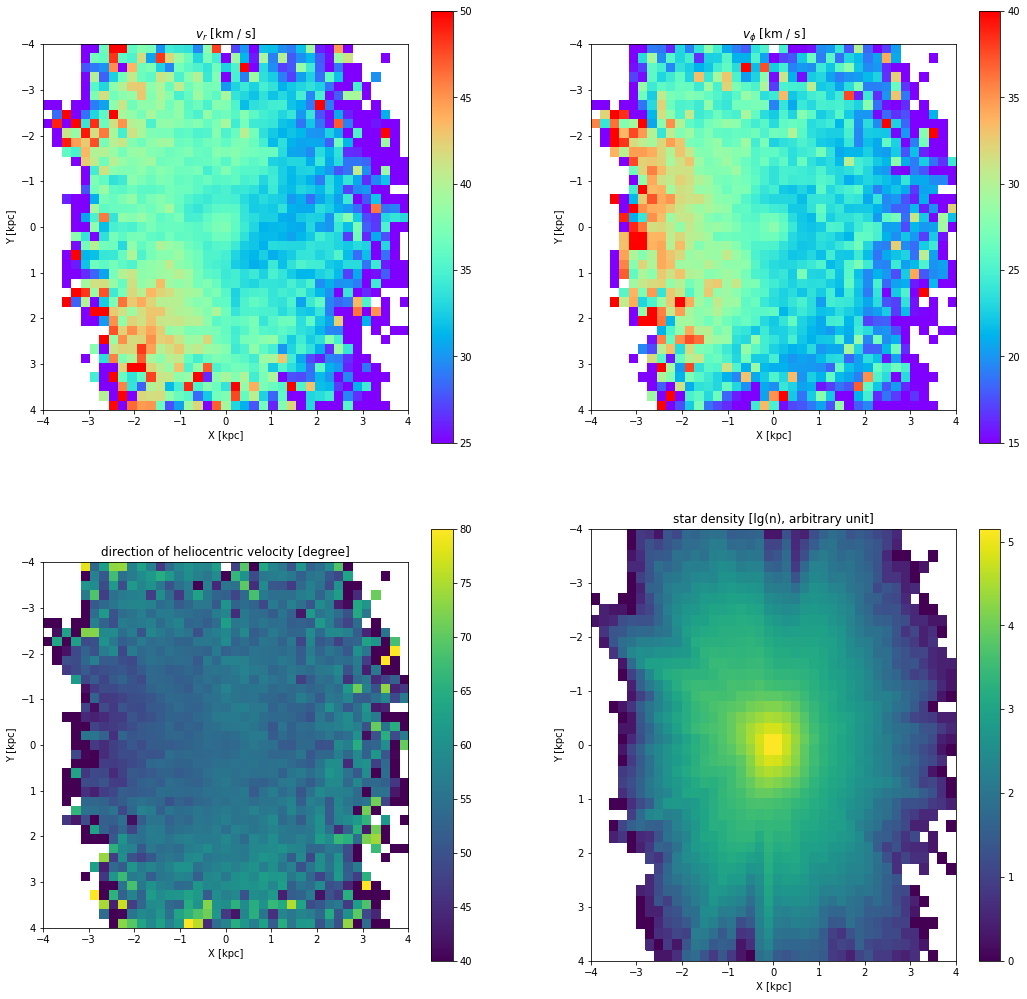

In [947]:
plt.figure(figsize=(18,27)) 

plt.subplot(3,2,3)
plt.title('direction of heliocentric velocity [degree]')
plt.imshow(vdirection_field_std,\
           extent=[x1,x2,y1,y2],vmin=40,vmax=80)
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.colorbar()

plt.subplot(3,2,4)
plt.title('star density [lg(n), arbitrary unit]')
H, xedges, yedges = np.histogram2d(X[selected], Y[selected], bins=(n, n),range=((x1,x2),(min(y1,y2),max(y1,y2))))
H = H.T
X_display, Y_display = np.meshgrid(xedges, yedges)
plt.pcolormesh(X_display, Y_display, np.log10(H))
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.xlim(x1,x2)
plt.ylim(y1,y2)
plt.colorbar()

plt.subplot(3,2,1)
plt.title('$v_r$ [km / s]')
plt.imshow(vr_field_std,\
           extent=[x1,x2,y1,y2],vmin=25,vmax=50,cmap='rainbow')
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.colorbar()

plt.subplot(3,2,2)
plt.title('$v_\phi$ [km / s]')
plt.imshow(vphi_field_std,\
           extent=[x1,x2,y1,y2],vmin=15,vmax=40,cmap='rainbow')
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.colorbar()


plt.show()

/home/scheng/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/home/scheng/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/home/scheng/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


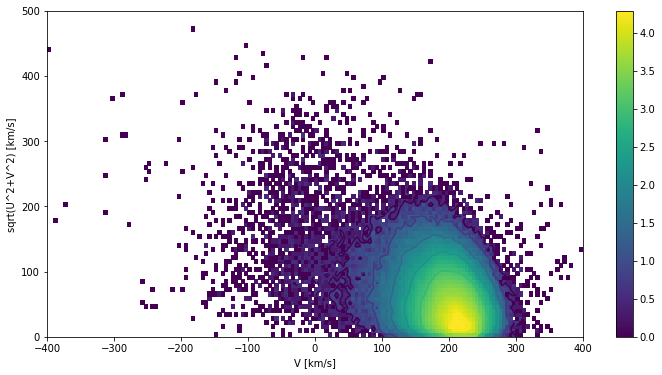

In [683]:
U = galactic.velocity.d_x
V = galactic.velocity.d_y
W = galactic.velocity.d_z

selected = (d > 0) * (e_d/d < 0.1) * (np.abs(bp_rp-0.75)<10.25) * (np.abs(Z.value-0)<0.1)\
                            *(rv.value>-100000) * (pm_abs.value>-100000000)


H, xedges, yedges = np.histogram2d(V[selected].value+230, np.sqrt(U[selected]**2+W[selected]**2), bins=(160, 80),range=((-400,400),(0,500)))
H = H.T
X_display, Y_display = np.meshgrid(xedges, yedges)

plt.figure(figsize=(12,6))
plt.pcolormesh(X_display, Y_display, np.log10(H))
plt.colorbar()
plt.contour(np.log10(H),extent=(-400,400,0,500))
plt.xlabel('V [km/s]')
plt.ylabel('sqrt(U^2+V^2) [km/s]')
plt.show()

In [ ]:
U = galactic.velocity.d_x
V = galactic.velocity.d_y
W = galactic.velocity.d_z

selected = (d > 0) * ((e_d/d) < 0.1) * (np.abs(bp_rp-0.75)<10.25) * (np.abs(Z.value+0.03)<0.005) * (np.abs(X.value-5)<12.5) *(rv.value>-100000) * (pm_abs.value>-100000000)

H, xedges, yedges = np.histogram2d(U[selected].value+13, ((V[selected].value)**1*0+(W[selected].value+7)**1*1), bins=(160, 160),range=((-200,200),(-200,200)))
H = H.T
X_display, Y_display = np.meshgrid(xedges, yedges)

plt.figure(figsize=(12,10))
plt.pcolormesh(X_display, Y_display, np.log10(H))
plt.colorbar()
plt.contour(np.log10(H),extent=(-200,200,-200,200))
plt.xlabel('$v_r$ [km/s]')
plt.ylabel('$v_t$ [km/s]')
plt.grid()
plt.show()

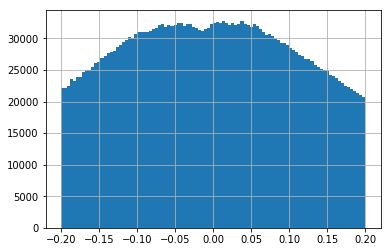

In [874]:
plt.grid()
plt.hist(Z.value,bins=100,range=(-0.2,0.2))
plt.show()

## XY distribution

/home/scheng/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/home/scheng/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/scheng/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


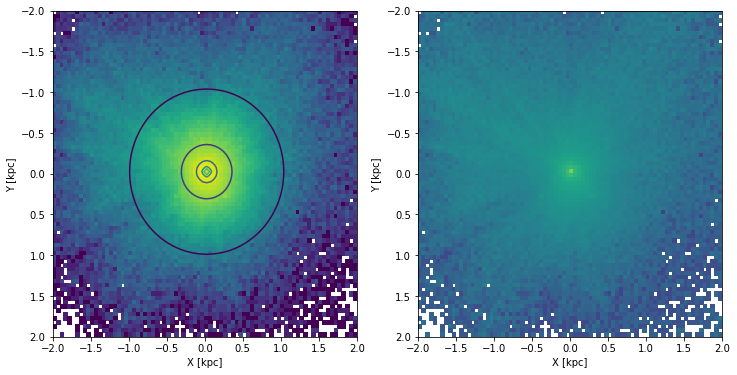

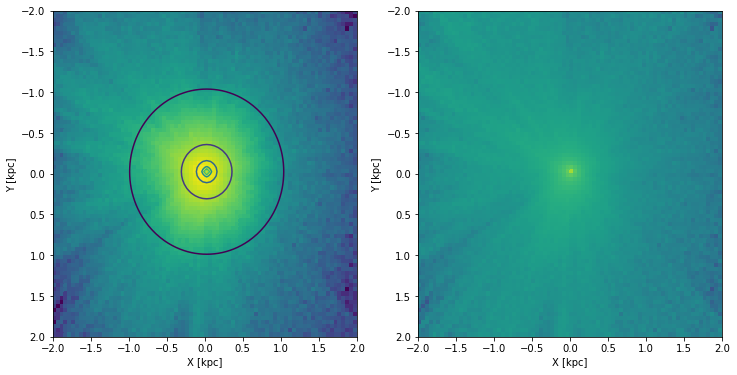

In [591]:
def plot_XY(selected):
    H, xedges, yedges = np.histogram2d(X[selected], Y[selected], bins=(80, 80),range=((-2,2),(-2,2)))
    H = H.T
    X_display, Y_display = np.meshgrid(xedges, yedges)
    
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    r = np.sqrt((X_display[:-1,:-1]**2+Y_display[1:,1:]**2)+0.0001)
    plt.pcolormesh(X_display, Y_display, np.log10(H))
    plt.contour(r**-.2,extent=(-2,2,-2,2))
    plt.xlabel('X [kpc]')
    plt.ylabel('Y [kpc]')
    plt.ylim(2,-2)
    
    plt.subplot(1,2,2)
    H_corr = H / density_radius_relation(r)
    plt.pcolormesh(X_display, Y_display, np.log10(H_corr), vmin=-5, vmax=1)
    plt.xlabel('X [kpc]')
    plt.ylabel('Y [kpc]')
    plt.ylim(2,-2)
    #plt.imshow(H)
    plt.show()

selected = (d > 0) * (e_d/d < 0.1) * (np.abs(bp_rp-0.75)<15) * (np.abs(Z.value-0)<0.2)\
                            *(rv.value>-100000) * (pm_abs.value>-100000000)\
                            * (np.abs(galactic.velocity.d_z.value+5)<50)\
                            * (np.abs(galactic.velocity.d_x.value+25)<20)\
                            * (np.abs(galactic.velocity.d_y.value+25)<10)
plot_XY(selected)

selected = (d > 0) * (e_d/d < 0.1) * (np.abs(bp_rp-0.75)<15) * (np.abs(Z.value-0)<0.2)\
                            *(rv.value>-100000) * (pm_abs.value>-100000000)\
                            * (np.abs(galactic.velocity.d_z.value+5)<10)#\
                            #* (np.abs(galactic.velocity.d_x.value)<20)\
                            #* (np.abs(galactic.velocity.d_y.value)<10)
plot_XY(selected)

In [580]:
H

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

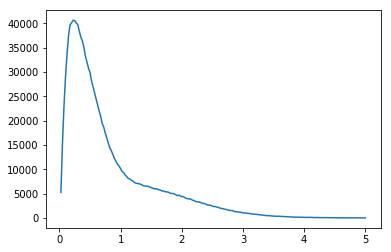

In [590]:
from scipy.interpolate import interp1d
density, bin_edge = np.histogram(np.sqrt(X.value**2+Y.value**2)[selected],bins=200,range=(0,5))
plt.plot(bin_edge[1:],density)
density_radius_relation = interp1d((bin_edge[1:]+bin_edge[:-1])/2, density,fill_value='extrapolate')
plt.show()

(array([3.20000e+01, 3.80000e+01, 3.10000e+01, 3.40000e+01, 3.90000e+01,
        3.80000e+01, 3.30000e+01, 4.00000e+01, 4.60000e+01, 4.70000e+01,
        3.40000e+01, 4.30000e+01, 5.40000e+01, 5.90000e+01, 5.00000e+01,
        3.80000e+01, 6.40000e+01, 6.70000e+01, 7.10000e+01, 7.50000e+01,
        1.00000e+02, 1.11000e+02, 1.70000e+02, 2.83000e+02, 4.62000e+02,
        7.65000e+02, 1.34200e+03, 2.25300e+03, 3.43500e+03, 5.33600e+03,
        7.83600e+03, 1.11510e+04, 1.55560e+04, 2.07040e+04, 2.71770e+04,
        3.59490e+04, 4.69690e+04, 5.98480e+04, 7.46390e+04, 9.14130e+04,
        1.06479e+05, 1.20711e+05, 1.34983e+05, 1.50400e+05, 1.71304e+05,
        2.05250e+05, 2.68252e+05, 3.75484e+05, 5.37746e+05, 7.14647e+05,
        6.64699e+05, 4.57051e+05, 2.98567e+05, 1.96065e+05, 1.32450e+05,
        9.73670e+04, 7.73020e+04, 6.39980e+04, 5.32660e+04, 4.41600e+04,
        3.53380e+04, 2.76770e+04, 2.11450e+04, 1.60910e+04, 1.19420e+04,
        9.18600e+03, 6.73200e+03, 5.17600e+03, 3.92

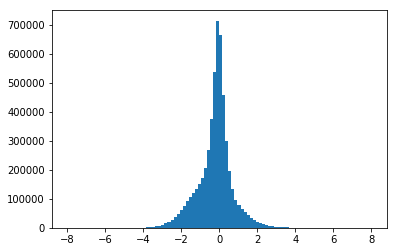

In [573]:
plt.hist(X.value,range=(-8,8),bins=100)

In [558]:
np.histogram?

## W [km/s] distribution

/home/scheng/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/home/scheng/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


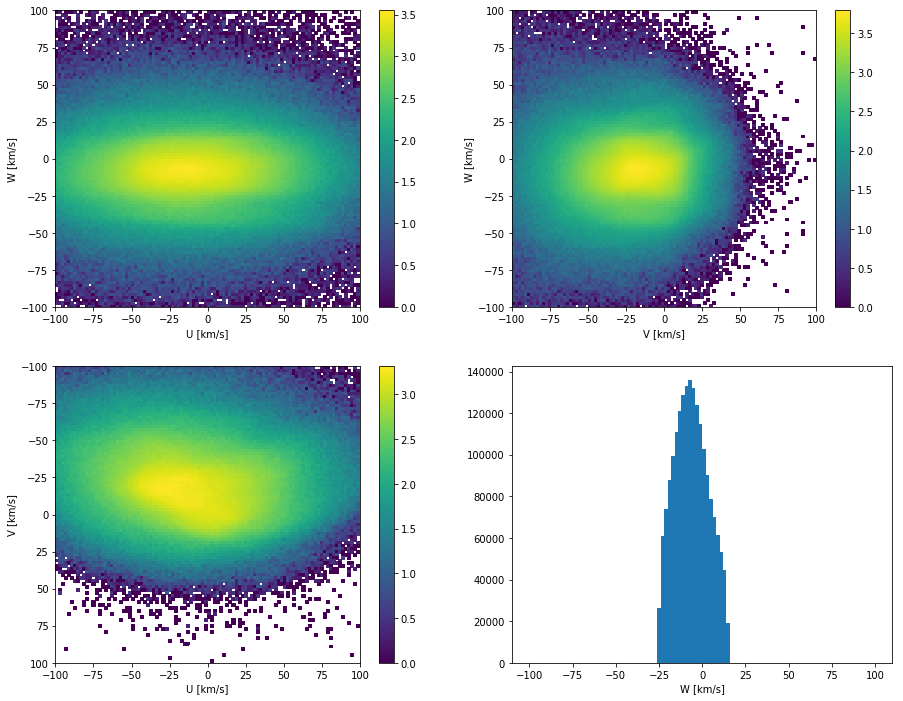

In [592]:
selected = (d.value<5)*(d > 0) * (e_d/d < 0.1) * (np.abs(bp_rp-0.75)<1) * (np.abs(Z.value-0)<0.2)\
                            *(rv.value>-100000) * (pm_abs.value>-100000000)
    
def plot_UVW(x,y,xlabel,ylabel):  
    H, xedges, yedges = np.histogram2d(x,y, bins=(100, 100),range=((-100,100),(-100,100)))
    H = H.T
    X_display, Y_display = np.meshgrid(xedges, yedges)
    
    plt.pcolormesh(X_display, Y_display, np.log10(H))
    #plt.colorbar()
    #plt.contour(H, extent=(-100,100,-100,100))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(-100,100)
    plt.colorbar()
    #plt.imshow(H)

plt.figure(figsize=(15,12))
plt.subplot(2,2,1)  
plot_UVW(galactic.velocity.d_x[selected], galactic.velocity.d_z[selected],'U [km/s]', 'W [km/s]')

plt.subplot(2,2,2)
plot_UVW(galactic.velocity.d_y[selected], galactic.velocity.d_z[selected],'V [km/s]', 'W [km/s]')

selected = selected = (d.value<5)*(d > 0) * (e_d/d < 0.1) * (np.abs(bp_rp-0.75)<1) * (np.abs(Z.value-0)<0.2)\
                            *(rv.value>-100000) * (pm_abs.value>-100000000)*\
                            (np.abs(galactic.velocity.d_z.value+5)<20)
plt.subplot(2,2,3)
plot_UVW(galactic.velocity.d_x[selected], galactic.velocity.d_y[selected],'U [km/s]', 'V [km/s]')
plt.ylim(100,-100)

plt.subplot(2,2,4)
plt.hist(galactic.velocity.d_z[selected].value,bins=100,range=(-100,100))
plt.xlabel('W [km/s]')
plt.show()

In [495]:
table.keys()

['source_id',
 'random_index',
 'ra',
 'dec',
 'l',
 'b',
 'parallax',
 'parallax_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'phot_g_mean_mag',
 'bp_rp',
 'radial_velocity',
 'a_g_val']

# All properties in CMD

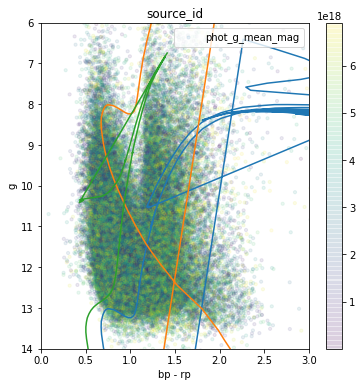

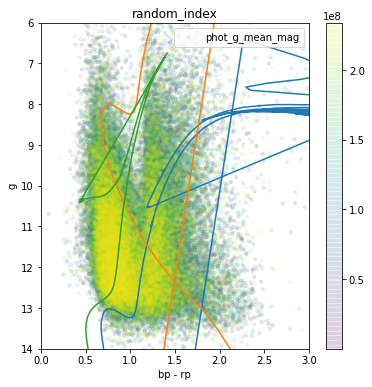

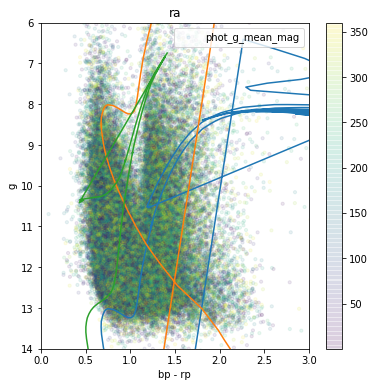

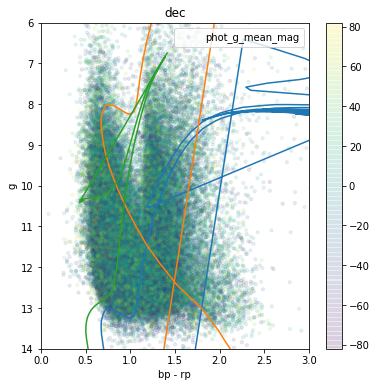

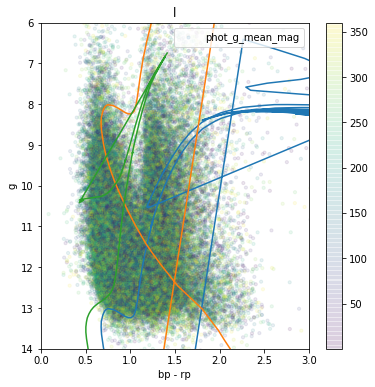

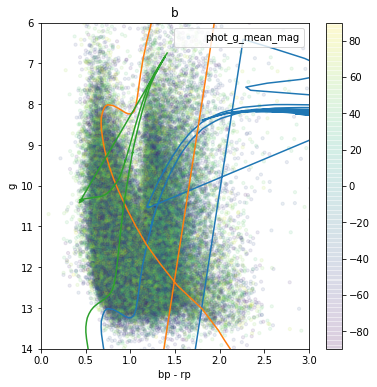

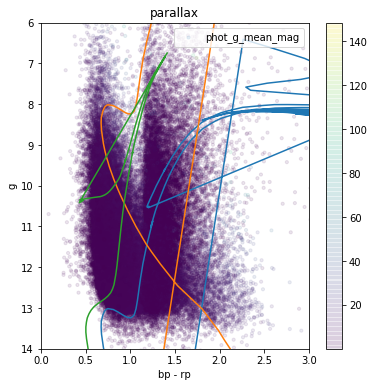

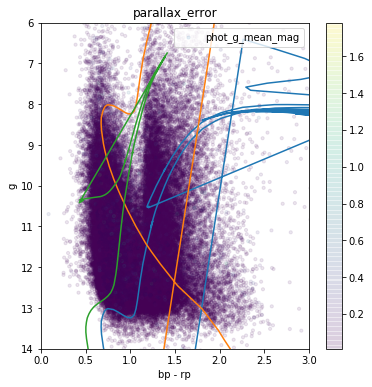

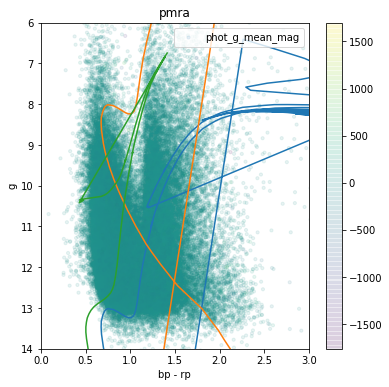

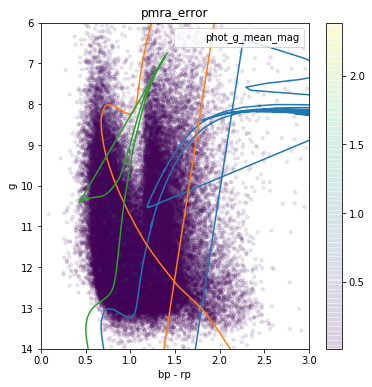

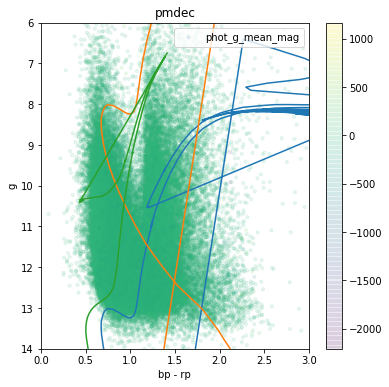

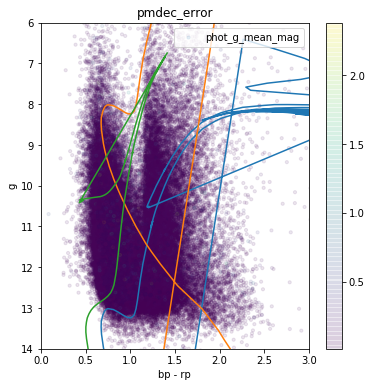

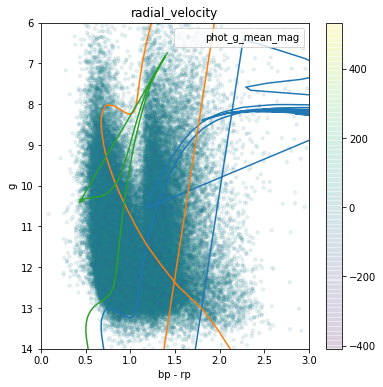

In [104]:
table = sample
for i,key in enumerate(table.keys()):
    if table[key].dtype == float or table[key].dtype == int:
        plt.figure(figsize=(6,6))
        selected = np.where((np.abs(table['b'])>35) \
                          )[0]
        #selected = np.where((np.abs(table.array['b'])>25) * (np.abs(table.array['bp_rp']-0.5)<0.2) \
        #                   * (np.abs(table.array['phot_g_mean_mag']-19.2)<1.5) \
        #                   * (np.abs(table.array['l']+80-360)<10) * (np.abs(table.array['b']+35)<10))[0]
        
        x = bp_rp
        y = g - table['a_g_val']
        z = table[key]
        plt.scatter(x[selected],y[selected],10,z[selected],alpha=0.1)#,label='RRc type')
        
        plt.legend()
        plt.colorbar()
        
        plt.title(key)
        plt.ylim(14,6)
        plt.xlim(-0.,3)
        plt.xlabel('bp - rp')
        plt.ylabel('g')
        
        plt.plot((isochrone_sun['G_BPmag']-isochrone_sun['G_RPmag']), isochrone_sun['Gmag']+10,'-')
        plt.plot((isochrone_sun['G_BPmag']-isochrone_sun['G_RPmag']), isochrone_sun['Gmag']+5,'-')
        plt.plot((isochrone_mpoor['G_BP']-isochrone_mpoor['G_RP']), isochrone_mpoor['G']+10,'-')
        
        
        plt.show()

/home/scheng/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


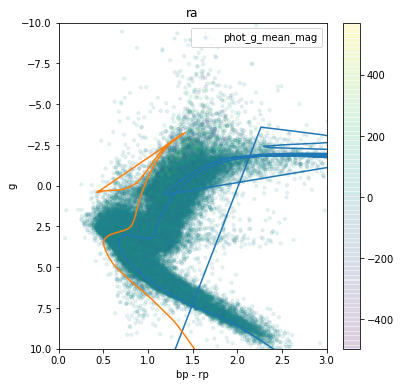

In [443]:
plt.figure(figsize=(6,6))
selected = np.where((np.abs(b)>35) #* (np.abs(d.value-1)<0.05)\
                  )[0]
#selected = np.where((np.abs(table.array['b'])>25) * (np.abs(table.array['bp_rp']-0.5)<0.2) \
#                   * (np.abs(table.array['phot_g_mean_mag']-19.2)<1.5) \
#                   * (np.abs(table.array['l']+80-360)<10) * (np.abs(table.array['b']+35)<10))[0]

x = bp_rp
y = g - (5*np.log10(d.value*1000)-5) #- table['a_g_val']
z = table['radial_velocity']
plt.scatter(x[selected],y[selected],10,z[selected],alpha=0.1)#,label='RRc type')

plt.legend()
plt.colorbar()

plt.title(key)
plt.ylim(10,-10)
plt.xlim(-0.,3)
plt.xlabel('bp - rp')
plt.ylabel('g')

plt.plot((isochrone_sun['G_BPmag']-isochrone_sun['G_RPmag']), isochrone_sun['Gmag'],'-')
#plt.plot((isochrone_sun['G_BPmag']-isochrone_sun['G_RPmag']), isochrone_sun['Gmag']+5,'-')
plt.plot((isochrone_mpoor['G_BP']-isochrone_mpoor['G_RP']), isochrone_mpoor['G'],'-')


plt.show()

In [539]:
selected.sum()

301210

/home/scheng/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/home/scheng/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/scheng/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


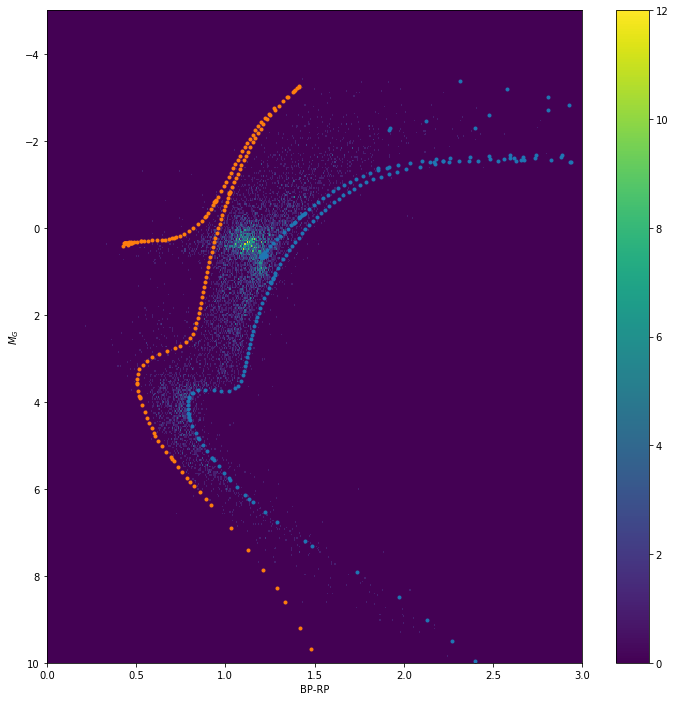

13513


In [642]:
selected = (d.value<5)*(d > 0) * (e_d/d < 0.1) * (np.abs(bp_rp-0.75)<20) * (np.abs(Z.value-0)>0.0)\
            *(rv.value>-100000) * (pm_abs.value>-100000000)\
            *~((np.abs(galactic.velocity.d_z.value+7)<50) * (np.abs(galactic.velocity.d_x.value-10)<50) * (np.abs(galactic.velocity.d_y.value+15)<50))\
            * (sfd_ext<0.1)\
            * (np.abs(galactic.velocity.d_y.value+200)<50)

x = (bp_rp-bayestar_ext/1.24)[selected]
y = (g - bayestar_ext*2.1 - (5*np.log10(d.value*1000)-5))[selected]
H, xedges, yedges = np.histogram2d(x,y, bins=(500, 500),range=((0,3),(-10,10)))
H = H.T
X_display, Y_display = np.meshgrid(xedges, yedges)

plt.figure(figsize=(12,12))
plt.pcolormesh(X_display, Y_display, (H))
#plt.colorbar()
#plt.contour(H, extent=(-100,100,-100,100))
plt.xlabel('BP-RP')
plt.ylabel(r'$M_G$')
plt.ylim(10,-5)
plt.xlim(0,3)
plt.colorbar()

#plt.plot((isochrone_sun['G_BPmag']-isochrone_sun['G_RPmag']), isochrone_sun['Gmag'],'.')
plt.plot((isochrone_old['G_BPmag']-isochrone_old['G_RPmag']), isochrone_old['Gmag'],'.')
plt.plot((isochrone_mpoor['G_BP']-isochrone_mpoor['G_RP']), isochrone_mpoor['G'],'.')


plt.show()
#plt.imshow(H)
print(selected.sum())